In [1]:
import sys
sys.path.insert(0, '../')

from nn_cno.io.sif import SIF
from nn_cno.io.midas import XMIDAS
from nn_cno.io.cnograph import CNOGraph
from nn_cno.core.base import CNOBase

from nn_cno.core import CNOBase, CNORBase
from nn_cno.core.params import  OptionsBase

from nn_cno.core.results import ODEResults
from nn_cno.core import ReportODE
from nn_cno.core.params import ParamsSSM

# from biokit.rtools import bool2R

from nn_cno.core.params import params_to_update


# Fixing `SIF` class
it is the basics of CNOGraph

In [2]:
toy_sif = SIF('./datasets/ToyMSB2009/PKN-ToyMSB2009.sif')

In [4]:
toy_sif.nodes1
toy_sif.nodes2

['EGFR',
 'Shc',
 'Grb2Sos',
 'Ras',
 'Raf',
 'MEK',
 'ERK',
 'Grb2Sos',
 'PI3K',
 'AKT',
 'GSK3',
 'IKKab',
 'TNFR',
 'IKKab',
 'TRADD',
 'C8',
 'C8',
 'Ikb',
 'NFkB',
 'MEK']

# Fixing `XMIDAS`
There was an error with missing `label` attribute of `multiIndex`. It was used to check if time 0 is missing. Fixed it by replacing it with `labels`

Note that some methods are not working, like `pca`

In [2]:
m = XMIDAS("./datasets/ToyMSB2009/MD-ToyMSB2009.csv")


In [3]:
m.df

AKT  C8  ERK  NFkB
cell experiment   time                    
test experiment_0 0       0   0    0     0
                  10      1   0    1     0
     experiment_1 0       0   0    0     0
                  10      0   1    0     0
     experiment_2 0       0   0    0     0
                  10      1   1    1     1
     experiment_3 0       0   0    0     0
                  10      0   0    1     0
     experiment_4 0       0   0    0     0
                  10      0   1    1     0
     experiment_5 0       0   0    0     0
                  10      1   0    0     0

In [10]:
m.experiments

Inhibitors     Stimuli     
                   PI3K Raf    TGFa TNFa
experiment_0          0   0       1    0
experiment_1          0   0       0    1
experiment_2          0   0       1    1
experiment_3          1   0       1    0
experiment_4          1   0       1    1
experiment_5          0   1       1    0

## Checking `CNOGraph` 

In [3]:
from nn_cno.io.cnograph import CNOGraph

In [4]:
c = CNOGraph()

In [5]:
c.add_edge("A", "B", link="+")
c.add_edge("A", "C", link="-")

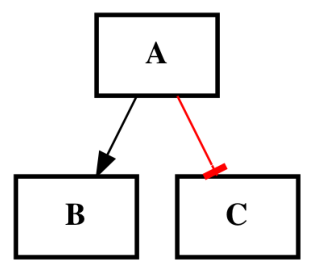

In [6]:
c.plot()
# Error:  AttributeError: 'CNOGraph' object has no attribute 'node'
# Problem: attributes of networkx.diGraph probably changed
# Fix: in  CNOgraph replace all `node` -> `_node`

import network from sif file

In [4]:
pkn = CNOGraph("../nn_cno/datasets/ToyMSB2009/PKN-ToyMSB2009.sif")

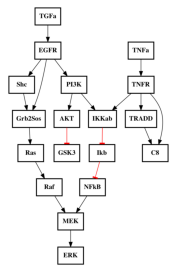

In [5]:
pkn.plot()

In [6]:
pkn.adjacency_matrix()

/Users/gabora/Documents/SaezGroup/LocalGitRepo/NN_cellnopt/nn_cno/../nn_cno/io/cnograph.py:1610: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(self, nodelist=nodelist).astype(int)


<18x18 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

# checking `CNOBase`
This is an abstract class. Other formalisms will use it.


# Checking Boolean formalism

In [2]:
model = CNOBase(pknmodel="../nn_cno/datasets/ToyMSB2009/PKN-ToyMSB2009.sif", data = "./datasets/ToyMSB2009/MD-ToyMSB2009.csv",verbose = True)

/Users/gabora/Documents/SaezGroup/LocalGitRepo/NN_cellnopt/nn_cno/../nn_cno/io/midas.py:2551: RuntimeWarning: invalid value encountered in true_divide
  return v/sumsq
/Users/gabora/Documents/SaezGroup/LocalGitRepo/NN_cellnopt/nn_cno/../nn_cno/io/midas.py:2523: RuntimeWarning: invalid value encountered in true_divide
  return self.values / float(self.values.max())
/Users/gabora/Documents/SaezGroup/LocalGitRepo/NN_cellnopt/nn_cno/../nn_cno/io/midas.py:2645: RuntimeWarning: All-NaN axis encountered
  if np.isnan(np.nanmax(values)):


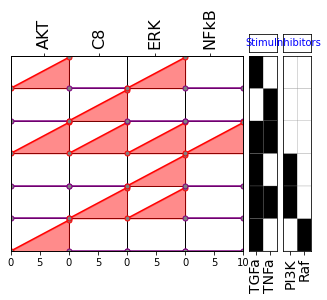

In [3]:
model.plot_midas()

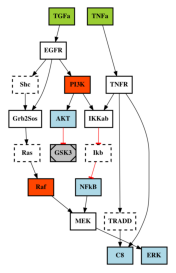

In [3]:
model.plot_pknmodel()

# `ODE` model


In [1]:
import sys
sys.path.insert(0, '../')
from nn_cno import cnodata, NNODE,CNOBase


building the model from SIF and MIDAS

In [9]:
c = NNODE("../nn_cno/datasets/working_case_study/PKN-test.sif",
    "./datasets/working_case_study/MD-test.csv")

In [10]:
# Note: model `nodes` keep AND relation as nodes:  NFkB^Raf=MEK
c._model.nodes
# len(c._model.nodes)

NodeView(('TGFa', 'EGFR', 'Shc', 'Grb2Sos', 'Ras', 'Raf', 'MEK', 'ERK', 'PI3K', 'AKT', 'GSK3', 'IKKab', 'TNFa', 'TNFR', 'TRADD', 'C8', 'Ikb', 'NFkB', 'NFkB^Raf=MEK'))

In [11]:
# entry i,j corresponds to edge from i to j. 

adj = c._model.adjacency_matrix(nodelist=c._model.nodes).todense()


/Users/gabora/Documents/SaezGroup/LocalGitRepo/NN_cellnopt/nn_cno/../nn_cno/io/cnograph.py:1613: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(self, nodelist=nodelist).astype(int)


Preprocessing: cut non-obserrvable and non-controllable. Right now we dont want expansion. 

In [12]:
c.preprocessing(expansion=False)

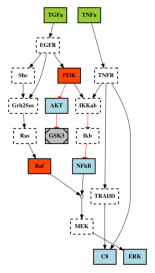

In [13]:
c.plot_pknmodel()

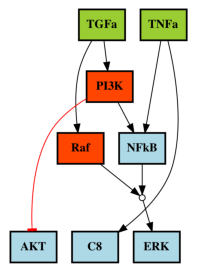

In [14]:
c.plot_model()

In [15]:
adj = nx.adjacency_matrix(c._model).todense()
adj

/var/folders/cx/9kyr3rt90c974wdygym_lhgh0000gn/T/ipykernel_43536/3932443868.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(c._model).todense()


matrix([[0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [37]:
c._model.edges["PI3K","AKT"]

{'attr_dict': None,
 'link': '-',
 'color': 'red',
 'arrowhead': 'tee',
 'penwidth': 1}

In [18]:
c._model.edges["PI3K","AKT"]

{'attr_dict': None,
 'link': '-',
 'color': 'red',
 'arrowhead': 'tee',
 'penwidth': 1}

In [46]:
c._model.reactions[0]



c._model.reac2edges(c._model.reactions[6])

[('TNFa', 'NFkB', '+')]

# building up the tools for ODE modelling

Let's assume we have a parameterized ODE model: 

`dx/dt = f(x,t,k,u)`

we want to solve the equations given some inital values (`x0`), time domain (`t \in [t_0, t_end]`) paramters `k` and input `u`. 
The right hand side `f(x,t,k,u)` is defined based on the PKN and MIDAS files.

I can see multiple options:

1. use PySB under the hood: maybe we could formulate reaction kinetics which could represent the information flow formalism. I think this is not really good, because it is just a workaround. Also I dont think they are compatible with jax.
2. generate the ODE system with Sympy. We could represent the whole ODE right hand side as an array of symbolic expressions, which could be evaluated at any point in the statespace. + there is a library( https://github.com/MilesCranmer/sympy2jax) which connects it to jax . This looks reasonable, but I dont know how much overhead is generated if we need to evaluate the array of  symbolic expressions 1k times for a single simulation. 
3. based on the model (SIF + MIDAS) we generate the adjacency matrix and other utility arrays and then we create a function that builds the right hand side of the ODE every time it is called by looking through the adjacency matrix. (this is the way logicODE is implemented in C). Since this involves only basic arithmetics and for loops, ifs, jax should be compatible with it. 
4. we use Sympy for the the symbolic building of the equation system and then we just write out the symbolic expressions as strings in a function. with string manipulation we make it compatible with jax. We did something similar during my phd: we got the model in MATLAB, then we wrote a  C-file and compiled it before the optimization started. In this case we would write a python file/function. 
5. we learn a new language: D

### Generate the right hand side on the fly

What do we need for the right hand side?
For a given state
- the incoming edges
- the sign of the edge
- boolean relationship of the edges. 

For Avlant's type network we only need the 

In [15]:
def get_right_hand_side(t,y,args):
    
    # we have to iterate through the states 
    states = args._model.nodes()





    

In [7]:
get_right_hand_side()

hello life


In [6]:
# !pip install sympy
import sympy as sym
import networkx as nx
import numpy as np
import scipy.sparse as sp

In [7]:
adj = nx.adjacency_matrix(c._model).todense()

/var/folders/cx/9kyr3rt90c974wdygym_lhgh0000gn/T/ipykernel_43536/3509652427.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(c._model).todense()


In [8]:
adj

matrix([[0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [56]:
plist = [ "p"+str(x) for x in range(len(c._model.species)**2) ]

str_mat = np.asarray(plist).reshape((-1,len(c._model.species)))

In [66]:
ind1, ind2, val = sp.find(adj)
ind1

array([ 0,  1,  1,  2,  3,  4,  5, 17,  6,  1,  8,  9,  8, 13, 12, 13, 13,
       14, 11, 16], dtype=int32)

In [68]:
states = c._model._get_namesSpecies()
observables = c._model.midas.signals
stimuli = c._model.midas.stimuli
inhibitors = c._model.midas.inhibitors

In [74]:
adj.todense()

matrix([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
def contruct_rhs(states, adj_vector, stimuli, inhibitors ):
    

In [69]:
s = sym.symbols(states)
f = list()
# construct the right hand side function for each state
for istate in range(0, len(states)):
    f = contruct_rhs(states=s, adj_vector=adj.todense()[istate,:], stimuli, inhibitors )


AttributeError: 'NNODE' object has no attribute 'parameters'

In [72]:
seq(states)

NameError: name 'seq' is not defined

In [53]:
sym_states = sym.symbols(observables.tolist())

NameError: name 'observables' is not defined

In [45]:
par = np.array([["a11","a12","a13"],["a21","a22","a23"],["a31","a32","a33"]])
states = np.array(["x1","x2","x3"])


spar = sym.symarray("p",shape=(3,3))
sstates = sym.symarray("x",shape=(3,1))

In [46]:
sstates

array([[x_0_0],
       [x_1_0],
       [x_2_0]], dtype=object)

In [48]:
spar@sstates

array([[p_0_0*x_0_0 + p_0_1*x_1_0 + p_0_2*x_2_0],
       [p_1_0*x_0_0 + p_1_1*x_1_0 + p_1_2*x_2_0],
       [p_2_0*x_0_0 + p_2_1*x_1_0 + p_2_2*x_2_0]], dtype=object)

In [50]:
spar[1,1] = 0

In [51]:
spar

array([[p_0_0, p_0_1, p_0_2],
       [p_1_0, 0, p_1_2],
       [p_2_0, p_2_1, p_2_2]], dtype=object)

In [52]:
spar@sstates

array([[p_0_0*x_0_0 + p_0_1*x_1_0 + p_0_2*x_2_0],
       [p_1_0*x_0_0 + p_1_2*x_2_0],
       [p_2_0*x_0_0 + p_2_1*x_1_0 + p_2_2*x_2_0]], dtype=object)